# IMPORTS 

In [19]:
import pandas as pd
pd.set_option("max_colwidth", None)

import pycaret
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import * 
from sklearn.model_selection import train_test_split
from scipy import stats
from functions.homebrew import *

# LOAD DATA

##### SIMPLE

In [3]:
# READ IN TRAIN
df = pd.read_csv('./data/fundraising.csv')
# SPLIT INTO TRAIN AND DEV
train, dev = train_test_split(df, test_size=0.20, random_state=42)
train['type'] = 'train'
dev['type'] = 'dev'

# READ IN TEST
test = pd.read_csv('./data/future_fundraising.csv')

# MAKE TARGET NANs
test['target'] = np.nan
test['type'] = 'test'

train_dev = pd.concat([train, dev], ignore_index=True, axis=0)
train_dev = train_dev.sample(frac=1).reset_index(drop=True)
df = pd.concat([train_dev, test], ignore_index=True, axis=0)
df.to_csv('./data/df.csv')

##### COMPLEX

In [4]:
# Interaction between 'income' and 'wealth'
df['interaction_wealth_income'] = df['income'] * df['wealth']

# Income to Home Value Ratio
df['income_to_home_ratio'] = df['income'] / df['home_value']

# Wealth to Home Value Ratio
df['wealth_to_home_ratio'] = df['wealth'] / df['home_value']

# Gift to Income Ratio
df['gift_to_income_ratio'] = df['lifetime_gifts'] / df['income']  # Assuming 'lifetime_gifts' is the total amount donated

# Average Gift Size to Largest Gift Ratio
df['average_gift_size_to_largest_gift_ratio'] = df['avg_gift'] / df['largest_gift']

# Total Gifts to Number of Promotions
df['total_gifts_to_number_of_promotions'] = df['lifetime_gifts'] / df['num_prom']

df['homeowner_children'] = df['homeowner'].astype(str) + "_" + df['num_child'].astype(str)

df['zip_gender'] = df['zipconvert2'].astype(str) + "_" + df['zipconvert3'].astype(str) + "_" + df['zipconvert4'].astype(str) + "_" + df['zipconvert5'].astype(str) + "_" + df['female'].astype(str)

df['time_since_last_gift_bucket'] = pd.cut(df['months_since_donate'], bins=[0, 6, 12, 24, np.inf], labels=['0-6', '7-12', '13-24', '24+'])
df.to_csv('./data/df_complex.csv')

# POST NN

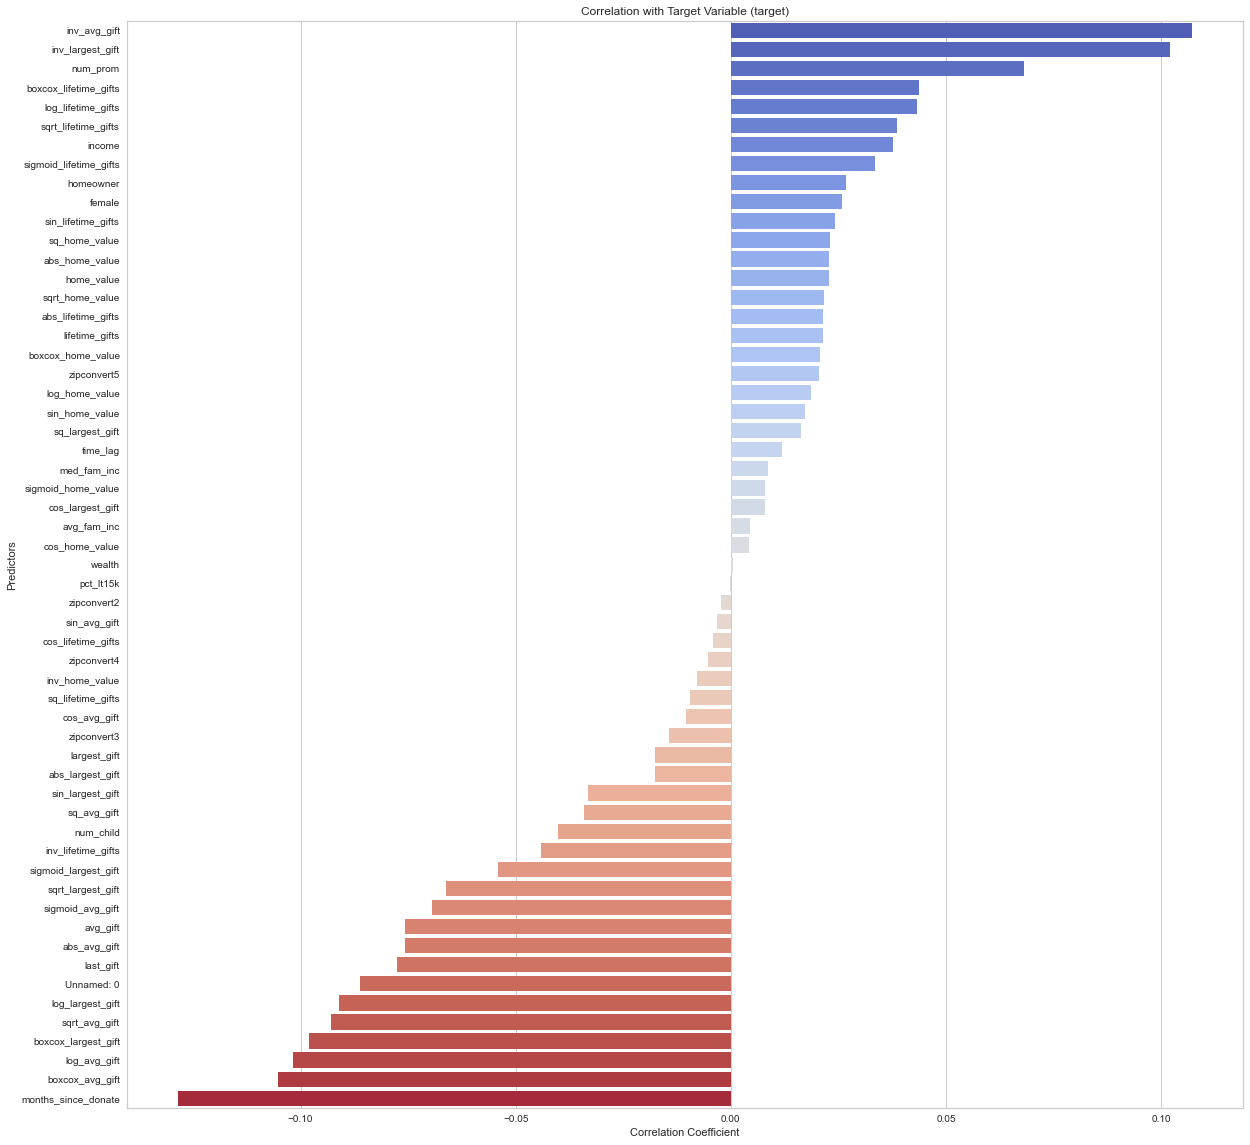

In [198]:
df = pd.read_csv('./data/df.csv')

pd.set_option("display.max_columns", None)
zip_columns = ['zipconvert2', 'zipconvert3', 'zipconvert4', 'zipconvert5']
for col in zip_columns:
    df[col] = (df[col] == 'Yes').astype(int)

df['homeowner'] = (df['homeowner'] == 'Yes').astype(int)
df['female'] = (df['female'] == 'Yes').astype(int)
df['target'] = (df['target'] == 'Donor').astype(int)

#df.drop(['zipconvert2', 'zipconvert3', 'zipconvert4', 'zipconvert5', 'type'], axis=1, inplace=True)
#test.drop(['zipconvert2', 'zipconvert3', 'zipconvert4', 'zipconvert5', 'type'], axis=1, inplace=True)

cat_cols = ['homeowner', 'female', 'zipconvert', 'wealth', 'income', 'num_child']
cont_cols = [col for col in df.columns if col not in cat_cols + ['target']]


variables = ['home_value', 'lifetime_gifts', 'largest_gift', 'avg_gift']
def add_transformations(df):
    for var in variables:
        # Log transformation
        df['log_' + var] = np.log(df[var] + 1)

        # Square transformation
        df['sq_' + var] = df[var]**2

        # Square root transformation
        df['sqrt_' + var] = np.sqrt(df[var])

        # Inverse transformation
        df['inv_' + var] = 1 / (df[var] + 1)

        # Box-Cox transformation
        df['boxcox_' + var], _ = stats.boxcox(df[var] + 1)

        # Absolute value transformation
        df['abs_' + var] = np.abs(df[var])

        # Sigmoid transformation
        df['sigmoid_' + var] = 1 / (1 + np.exp(-df[var]))

        # Trigonometric transformations
        df['sin_' + var] = np.sin(df[var])
        df['cos_' + var] = np.cos(df[var])
        
add_transformations(df)
add_transformations(test)

# Summary statistics
# print(df.describe())

# Correlation matrix
def cor_bars(df):
    corr = df.corr()
    # plt.figure(figsize=(20, 20))
    # sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    # plt.show()

    # Isolating the column that represents the correlation with the target variable
    target_corr = corr['target'].sort_values(ascending=False)

    # Removing the target variable from itself to avoid a perfect correlation display
    target_corr = target_corr.drop(labels=['target'])

    # Display the correlations
    # print(target_corr)

    # Plotting the correlations for visual representation
    plt.figure(figsize=(20, 20))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
    plt.title('Correlation with Target Variable (target)')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Predictors')
    plt.show()
cor_bars(df)

In [199]:
kept = [df.corr()[ np.abs(df.corr()['target']) >.05].index]

# Assuming `kept` is a list containing a single pandas Index object
if isinstance(kept[0], pd.Index):
    kept_columns = kept[0].tolist()  # Convert the Index to a list
else:
    kept_columns = kept  # If `kept` is already a list of column names

# Append 'target' to the list of column names
kept_columns.append('target')

# Now you can use this list to index your DataFrame
df_subset = df[kept_columns]


In [200]:
df['type']

0       train
1       train
2         dev
3       train
4       train
        ...  
3115     test
3116     test
3117     test
3118     test
3119     test
Name: type, Length: 3120, dtype: object

In [202]:
df_subset['type'] = df['type']

In [204]:
df_subset.to_csv('./data/tiny.csv')